In [1]:
import argparse
import os
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch.utils.data import DataLoader
from plotter import TensorboardPlotter
from dataset import *
from model import *

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device : ", device)

# Load model
model = AdversarialMTL3(hidden_unit=128)
model.to(device)
model.load_state_dict(torch.load('./model/ADMTL3/smote.pth', map_location=device))
print("Model loaded")

Device :  cpu
Model loaded


In [3]:
data = Adversarial3Dataset(mode='test')
print("Dataset created")

print(type(data))
data_feature = data.features
print(type(data))
data_feature = torch.from_numpy(data_feature).float().to(device)
print(type(data_feature))
print(data_feature.shape)
data_feature.to(device)

Dataset created
<class 'dataset.Adversarial3Dataset'>
<class 'dataset.Adversarial3Dataset'>
<class 'torch.Tensor'>
torch.Size([286, 16])


tensor([[ 1.0000, -1.5299,  0.1361,  ..., -0.4376, -0.8942, -0.7338],
        [ 1.0000, -0.9710, -0.3725,  ..., -0.5328, -0.5786, -0.2068],
        [ 1.0000,  1.0419, -0.2888,  ...,  0.7742, -1.0691, -0.2746],
        ...,
        [ 1.0000, -0.0439, -0.2540,  ..., -0.7450, -0.2559, -0.0051],
        [ 0.0000,  0.6419, -0.3725,  ..., -1.0525, -1.0691, -1.3898],
        [ 1.0000, -0.7297, -0.5742,  ...,  0.4528, -0.2826, -0.0027]])

In [4]:
out0,out1, out2, ad, _ = model(data_feature)
outputs = torch.cat((out0,out1, out2), dim=1)
outputs.to(device)

tensor([[9.1084e-01, 7.6058e-02, 2.0022e-02],
        [9.0129e-01, 9.0429e-02, 1.4372e-02],
        [9.8934e-01, 1.7764e-01, 4.9243e-04],
        [8.7211e-01, 1.5528e-03, 4.8746e-02],
        [7.6002e-01, 6.4967e-02, 7.5374e-02],
        [8.7830e-01, 1.3176e-01, 2.4948e-02],
        [9.9181e-01, 7.1447e-07, 6.6034e-03],
        [8.4216e-01, 6.0204e-02, 6.7760e-02],
        [8.7589e-01, 8.5437e-02, 6.7223e-02],
        [9.6834e-01, 6.3945e-05, 6.9248e-02],
        [8.9026e-01, 4.7070e-04, 3.8276e-01],
        [6.1949e-01, 2.8156e-01, 1.1187e-01],
        [9.8925e-01, 2.4949e-01, 1.4715e-04],
        [8.6348e-01, 6.0412e-02, 1.0801e-01],
        [8.0976e-01, 2.1436e-01, 8.3258e-02],
        [7.4411e-20, 4.1977e-14, 1.0000e+00],
        [8.4215e-01, 5.8158e-03, 3.6773e-02],
        [9.0627e-01, 1.6239e-02, 9.5360e-02],
        [6.2712e-01, 2.0754e-02, 2.1703e-02],
        [4.9691e-01, 1.4771e-01, 1.8578e-01],
        [8.1438e-01, 3.0530e-01, 1.2483e-01],
        [9.6147e-01, 4.3845e-02, 1

In [5]:
print(ad.shape)
outputs_ad = torch.cat((out0,out1,out2,ad),dim=1)
print(outputs_ad.shape)

torch.Size([286, 3])
torch.Size([286, 6])


In [6]:
out1.device

device(type='cpu')

In [7]:
import SHAP

In [8]:
explainer = SHAP.DeepExplainer(model, data_feature, 'ADMTL3')
shape_values = explainer.shap_values(data_feature)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [10]:
print(len(shape_values))
print(shape_values[0].shape)
print(shape_values[1].shape)


6
(286, 16)
(286, 16)


In [11]:
# '진단시점나이'를 age 로 변환
feature_names = data.feature_names

for name in feature_names:
    if name == '진단시점나이':
        feature_names[feature_names.index(name)] = 'age'
print(feature_names)

['Gender', 'age', 'CMV IgM[Serum]', 'CMV IgG[Serum]', 'HSV IgM[Serum]', 'VZV IgM[Serum]', 'VZV IgG[Serum]', 'WBC COUNT[Whole blood]', 'Lymphocyte(#)[Whole blood]', 'Lymphocyte(%)[Whole blood]', 'Monocyte(#)[Whole blood]', 'Monocyte(%)[Whole blood]', 'Neutrophil(#)[Whole blood]', 'Neutrophil(%)[Whole blood]', 'ESR[Whole blood]', 'CRP[Serum]']


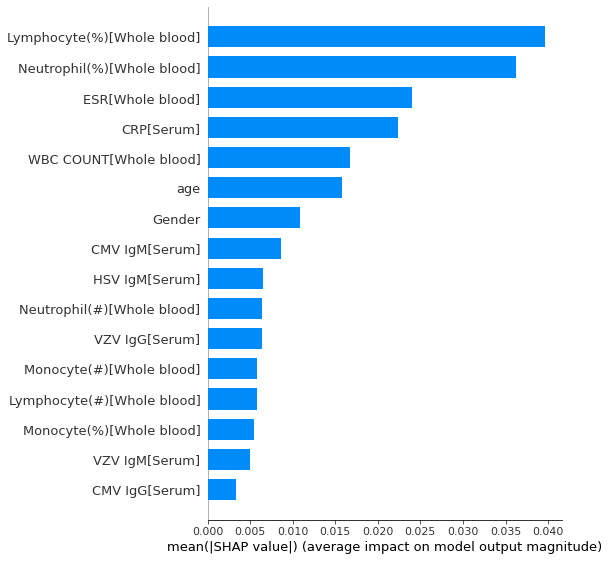

In [12]:
SHAP.summary_plot(shape_values[0], data_feature, plot_type="bar", feature_names=feature_names)

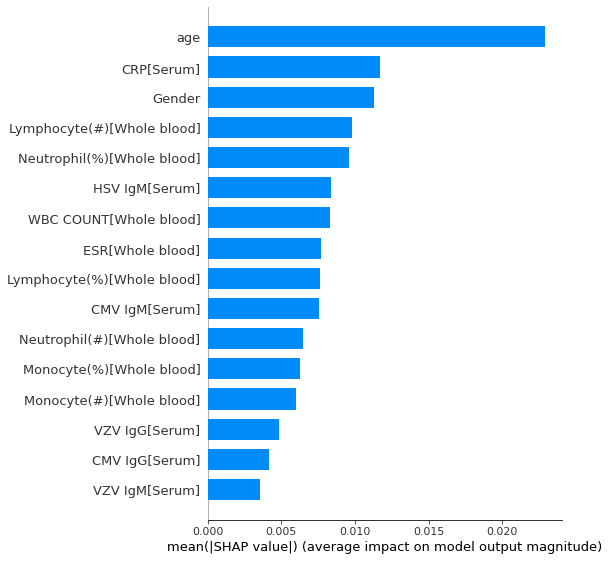

In [13]:
SHAP.summary_plot(shape_values[1], data_feature, plot_type="bar", feature_names=feature_names)

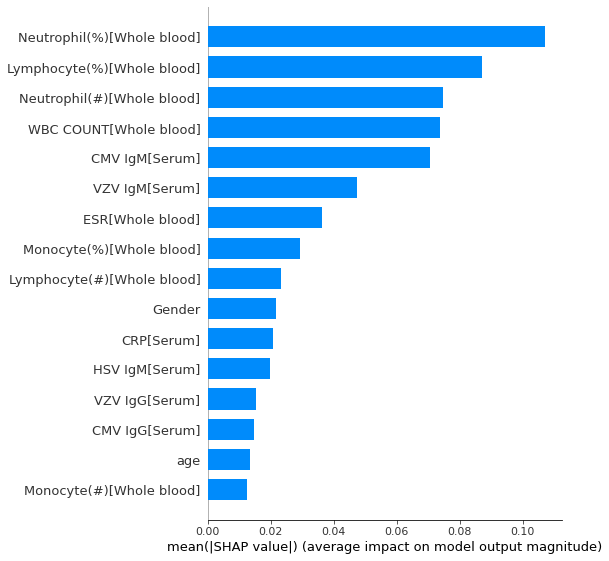

In [14]:
SHAP.summary_plot(shape_values[2], data_feature, plot_type="bar", feature_names=feature_names)

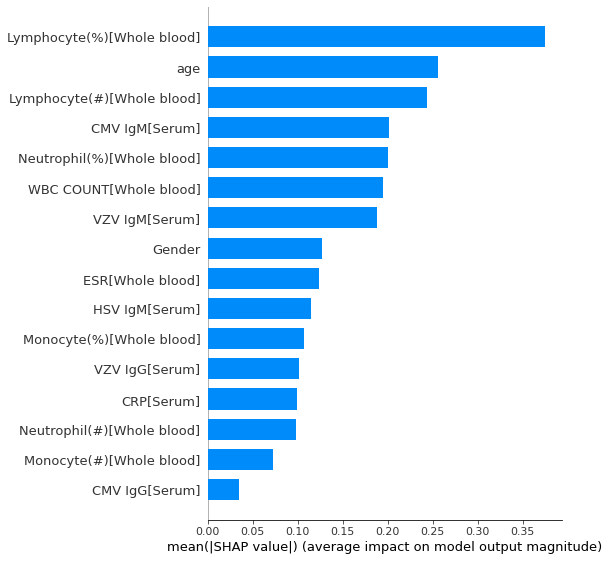

In [15]:
SHAP.summary_plot(shape_values[3], data_feature, plot_type="bar", feature_names=feature_names)